In [6]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re


import geopandas as gpd
import plotly.express as px
from shapely.geometry import Point
import seaborn as sns
import missingno as msno

pd.set_option('display.max_columns', None)  # Display all columns

In [7]:
df = pd.read_csv('/content/Electric_Vehicle_Population_Data.csv')

In [8]:
# View first 10 value on the Dataframe
display(df.head(10))

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
1,5YJ3E1EA7K,San Diego,San Diego,CA,92101.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6.073005e+09
2,7JRBR0FL9M,Lane,Eugene,OR,97404.0,2021,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,0,NaN,144502018,POINT (-123.12802 44.09573),NaN,4.103900e+10
3,5YJXCBE21K,Yakima,Yakima,WA,98908.0,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
4,5UXKT0C5XH,Snohomish,Bothell,WA,98021.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10
5,1N4AZ0CP4F,Snohomish,Everett,WA,98201.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,38.0,107901699,POINT (-122.20596 47.97659),PUGET SOUND ENERGY INC,5.306104e+10
6,5YJ3E1EBXJ,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,23.0,475036313,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303594e+10
7,WDC0G5EB0K,Yakima,Naches,WA,98937.0,2019,MERCEDES-BENZ,GLC-CLASS,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,10,0,14.0,338148968,POINT (-120.69972 46.7309),PACIFICORP,5.307700e+10
8,1N4AZ0CP3D,Kitsap,Port Orchard,WA,98366.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,26.0,249239623,POINT (-122.63847 47.54103),PUGET SOUND ENERGY INC,5.303509e+10
9,KNDCC3LD9K,Kitsap,Olalla,WA,98359.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26,0,26.0,475609368,POINT (-122.54729 47.42602),PUGET SOUND ENERGY INC,5.303509e+10


PRE PROCESSING

Menangani Nilai yang Hilang dengan Menghapus Baris¶

Dalam dataset kami, kami telah mengamati bahwa hanya sejumlah kecil baris yang memiliki nilai yang hilang di beberapa kolom. Mengingat ukuran keseluruhan dataset, menghapus baris-baris ini kemungkinan hanya akan berdampak minimal pada akurasi dan representativitas analisis kami. Selain itu, menghapus baris-baris dengan nilai yang hilang adalah pendekatan yang sederhana dan langsung yang memungkinkan kami untuk bekerja dengan dataset yang bersih tanpa harus membuat asumsi atau mengimput nilai yang dapat memperkenalkan bias atau kesalahan dalam analisis kami.

Kolom-kolom berikut memiliki nilai yang hilang:

- Model (78 nilai yang hilang)
- Jangkauan Elektrik (1 nilai yang hilang)
- MSRP Dasar (1 nilai yang hilang)
- Distrik Legislatif (148 nilai yang hilang)
- ID Kendaraan DOL (1 nilai yang hilang)
- Lokasi Kendaraan (19 nilai yang hilang)
- Utilitas Elektrik (227 nilai yang hilang)
- Blok Sensus 2020 (1 nilai yang hilang)

Mengingat jumlah nilai yang hilang relatif kecil di kolom-kolom ini, kami dapat dengan aman menghapus baris-baris ini tanpa mempengaruhi dataset secara signifikan. Dengan cara ini, kami dapat melanjutkan analisis kami menggunakan dataset yang bebas dari nilai yang hilang.

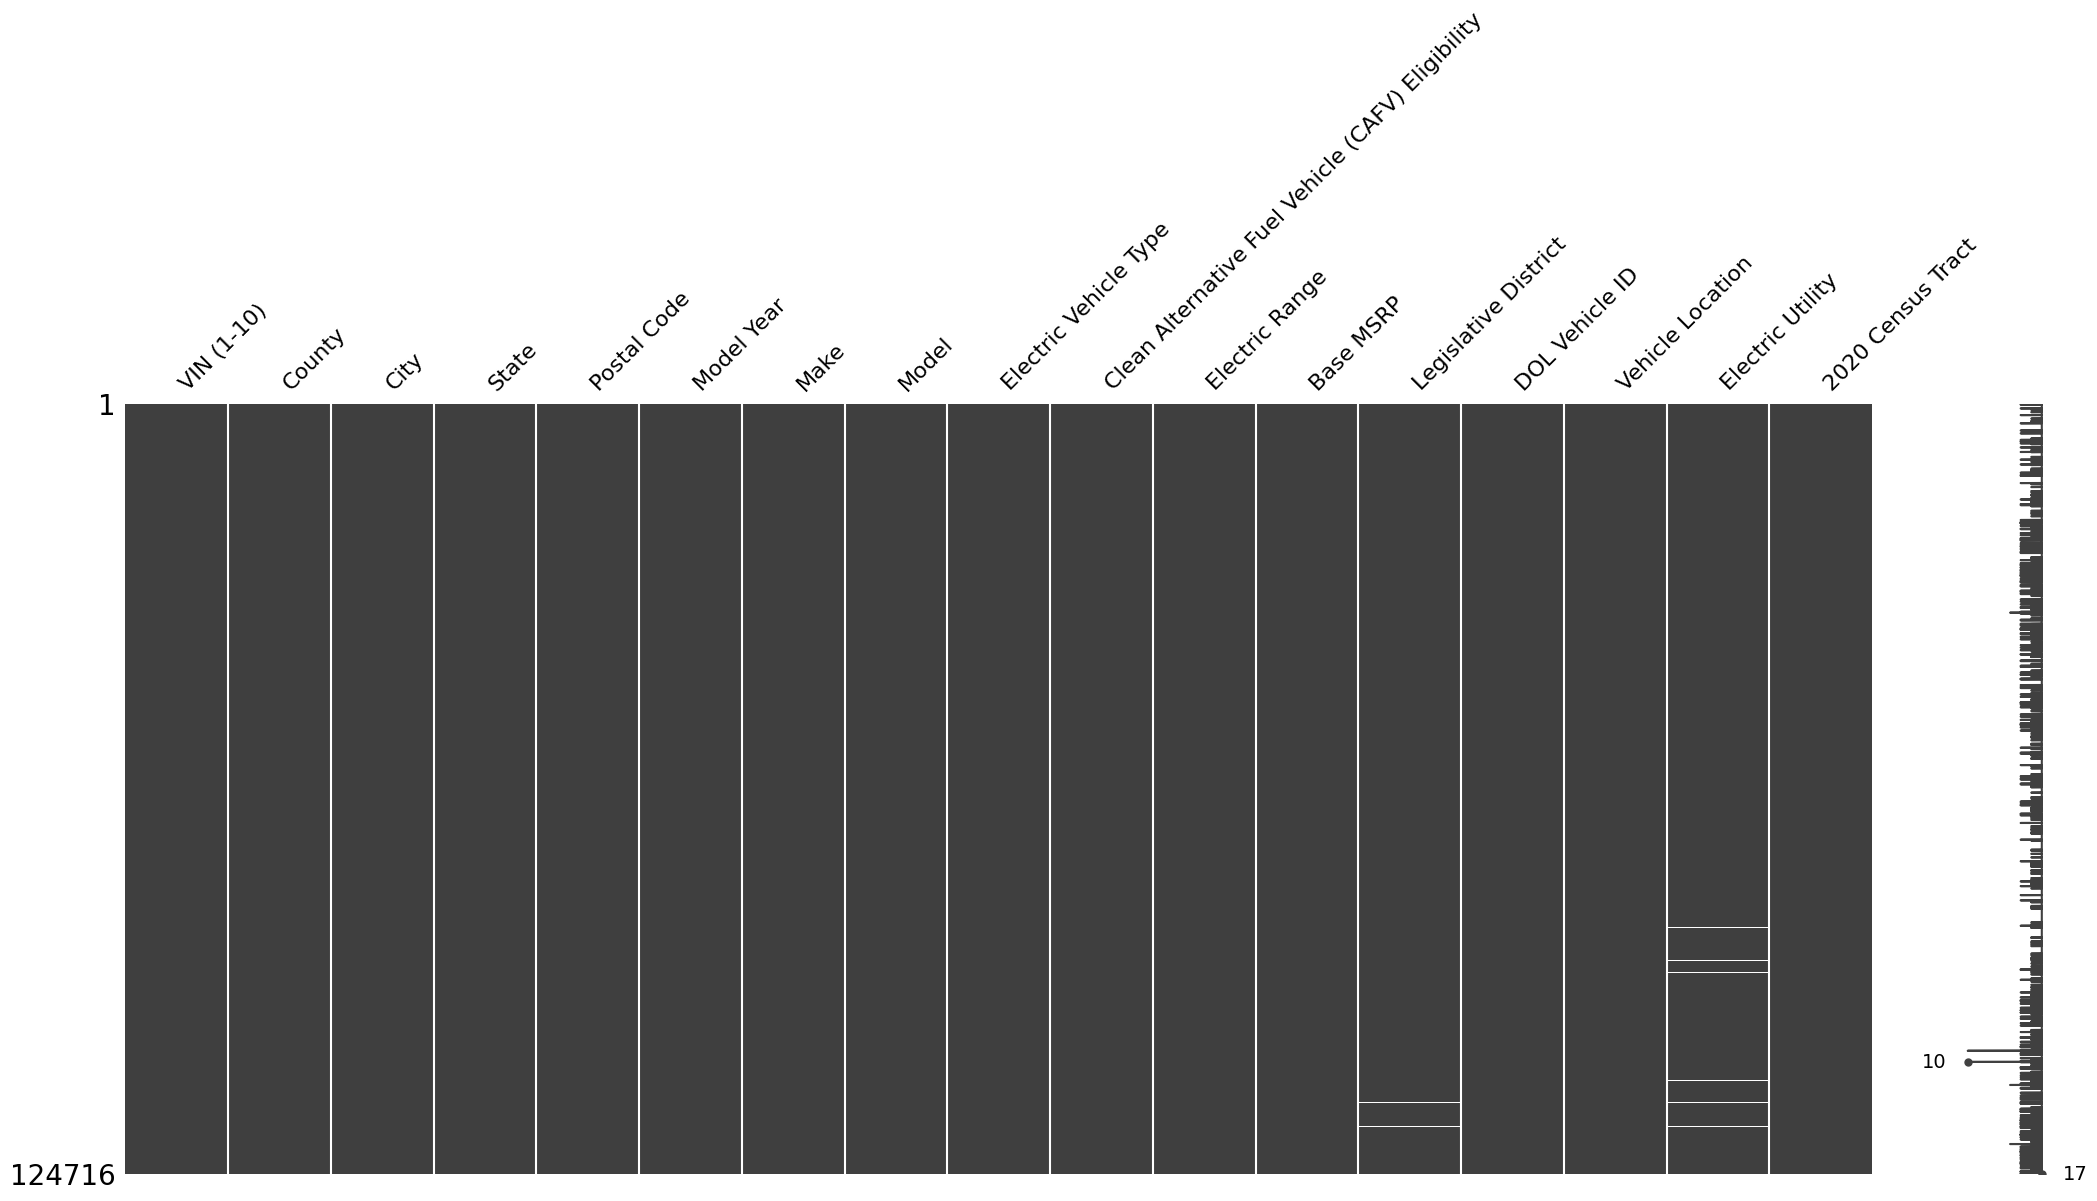

In [9]:
# Visualize missing values using missingno
msno.matrix(df);

In [10]:
# Dropping the missing values
df = df.dropna()

🛠️ Rekayasa Fitur

Rekayasa Fitur: Mengambil Latitude dan Longitude Dalam dataset kami, kolom Lokasi Kendaraan berisi koordinat latitude dan longitude dalam bentuk string. Untuk membuat koordinat ini lebih mudah diakses untuk analisis lebih lanjut, kami akan melakukan langkah-langkah rekayasa fitur berikut:

Konversi kolom Lokasi Kendaraan ke tipe string.
Buat dua kolom baru di DataFrame, latitude dan longitude.
Ekstrak nilai latitude dan longitude dari kolom Lokasi Kendaraan dan simpan di kolom baru tersebut.
Untuk mencapai ini, kami mendefinisikan sebuah fungsi bernama extract_coordinates(), yang menerima dua argumen: string input (berisi koordinat) dan indeks (0 untuk latitude dan 1 untuk longitude). Fungsi ini menggunakan ekspresi reguler untuk menemukan dan mengembalikan angka floating-point yang mewakili koordinat. Kami kemudian menggunakan fungsi apply() untuk menerapkan fungsi kustom ini ke setiap elemen kolom Lokasi Kendaraan dan mengisi kolom latitude dan longitude baru.

Terakhir, kami menghapus baris-baris dengan nilai yang hilang di kolom latitude dan longitude untuk memastikan dataset yang bersih untuk analisis lebih lanjut.

In [11]:
# Convert the 'Vehicle Location' column to string type
df['Vehicle Location'] = df['Vehicle Location'].astype(str)

# Extract the latitude and longitude from the 'Vehicle Location' column
def extract_coordinates(x, index):
    coords = re.findall(r'-?\d+\.\d+', x)
    if len(coords) >= 2:
        return float(coords[index])
    else:
        return None

df['latitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 0))
df['longitude'] = df['Vehicle Location'].apply(lambda x: extract_coordinates(x, 1))

df = df.dropna(subset=['latitude', 'longitude'])

Rekayasa Fitur: Membuat Kolom 'Location' Dalam dataset kami, kami memiliki tiga kolom yang mewakili tingkat pembagian geografis yang berbeda: County, City, dan State. Untuk membuat representasi geografis yang lebih informatif dan digabungkan, kami akan membuat kolom baru bernama Location.

Kolom Location akan menjadi hasil penggabungan kolom County, City, dan State, dengan setiap nilai dipisahkan oleh koma. Misalnya, jika sebuah baris memiliki nilai "Yakima" untuk County, "Yakima" untuk City, dan "WA" untuk State, nilai Location yang sesuai akan menjadi "Yakima, Yakima, WA".

In [12]:
df['Location'] = df['County'] + ', ' + df['City'] + ', ' + df['State']

Rekayasa Fitur: Membuat Kolom Price_Range_Category Dalam dataset kami, kami mengamati distribusi nilai yang tidak biasa di kolom MSRP Dasar, dengan sejumlah besar kendaraan memiliki nilai 0. Ini bisa menunjukkan nilai yang hilang atau tidak diketahui dalam dataset. Untuk mengatasi ketidakpastian ini dan tetap memanfaatkan data yang tersedia, kami memutuskan untuk membuat kolom baru bernama Price_Range_Category berdasarkan nilai MSRP Dasar.

Kami telah mendefinisikan empat kategori untuk kolom Price_Range_Category:

"Unknown": Jika nilai MSRP Dasar adalah 0, kami menetapkan kategori ini karena mungkin menunjukkan nilai yang hilang atau tidak diketahui.
"Low": Jika nilai MSRP Dasar kurang dari 40.000, kami menetapkan kategori ini.
"Medium": Jika nilai MSRP Dasar antara 40.000 dan 60.000, kami menetapkan kategori ini.
"High": Jika nilai MSRP Dasar lebih dari 60.000, kami menetapkan kategori ini.
Dengan membuat kolom baru ini, kami dapat lebih memahami distribusi harga kendaraan listrik dalam dataset kami dan mengatasi ketidakpastian potensial yang diperkenalkan oleh sejumlah besar nilai 0 di kolom MSRP Dasar.

In [13]:
df['Base MSRP'].value_counts()

,count
Base MSRP,
0,120656
69900,1429
31950,402
52900,167
32250,155
54950,138
59900,127
39995,119
36900,98


In [14]:
def create_price_range_category(df, column='Base MSRP'):
    def categorize_price(price):
        if price == 0:
            return "Unknown"
        elif price < 40000:
            return "Low"
        elif price < 60000:
            return "Medium"
        else:
            return "High"

    df['Price_Range_Category'] = df[column].apply(categorize_price)
    return df

df = create_price_range_category(df, column='Base MSRP')

Rekayasa Fitur: Membuat Kolom 'Electric_Range_Category' Dalam dataset kami, kami mengamati distribusi nilai yang tidak biasa di kolom 'Jarak Listrik', dengan sejumlah besar kendaraan memiliki nilai 0. Ini bisa menunjukkan nilai yang hilang atau tidak diketahui dalam dataset. Untuk mengatasi ketidakpastian ini dan tetap memanfaatkan data yang tersedia, kami memutuskan untuk membuat kolom baru bernama 'Electric_Range_Category' berdasarkan nilai 'Jarak Listrik'.

Kami telah mendefinisikan empat kategori untuk kolom 'Electric_Range_Category':

"Unknown": Jika nilai 'Jarak Listrik' adalah 0, kami menetapkan kategori ini karena mungkin menunjukkan nilai yang hilang atau tidak diketahui.
"Short": Jika nilai 'Jarak Listrik' kurang dari 150, kami menetapkan kategori ini.
"Medium": Jika nilai 'Jarak Listrik' antara 150 dan 300, kami menetapkan kategori ini.
"Long": Jika nilai 'Jarak Listrik' lebih dari 300, kami menetapkan kategori ini.
Dengan membuat kolom baru ini, kami dapat lebih memahami distribusi jangkauan kendaraan listrik dalam dataset kami dan mengatasi ketidakpastian potensial yang diperkenalkan oleh sejumlah besar nilai 0 di kolom 'Jarak Listrik'.

In [15]:
def create_electric_range_category(df, column='Electric Range'):
    def categorize_range(electric_range):
        if electric_range == 0:
            return "Unknown"
        elif electric_range < 150:
            return "Short"
        elif electric_range < 300:
            return "Medium"
        else:
            return "Long"

    df['Electric_Range_Category'] = df[column].apply(categorize_range)
    return df

df = create_electric_range_category(df, column='Electric Range')

In [16]:
# Displaying the cleaned and feature engineered DataFrame
display(df.head())

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,latitude,longitude,Location,Price_Range_Category,Electric_Range_Category
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10,-120.56916,46.58514,"Yakima, Yakima, WA",Unknown,Long
3,5YJXCBE21K,Yakima,Yakima,WA,98908.0,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10,-120.56916,46.58514,"Yakima, Yakima, WA",Unknown,Medium
4,5UXKT0C5XH,Snohomish,Bothell,WA,98021.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10,-122.18384,47.80310,"Snohomish, Bothell, WA",Unknown,Short
5,1N4AZ0CP4F,Snohomish,Everett,WA,98201.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,0,38.0,107901699,POINT (-122.20596 47.97659),PUGET SOUND ENERGY INC,5.306104e+10,-122.20596,47.97659,"Snohomish, Everett, WA",Unknown,Short
6,5YJ3E1EBXJ,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,23.0,475036313,POINT (-122.64681 47.73689),PUGET SOUND ENERGY INC,5.303594e+10,-122.64681,47.73689,"Kitsap, Poulsbo, WA",Unknown,Medium


📊 Analisis Data Eksploratif

Pada bagian ini, kami akan melakukan analisis data eksploratif (EDA) pada dataset mobil listrik. Tujuan dari EDA adalah untuk mendapatkan wawasan dan pemahaman tentang dataset, mengidentifikasi pola, hubungan, dan anomali. Melalui EDA, kami dapat membuat keputusan yang terinformasi tentang bagaimana memproses dan memodelkan data, serta menghasilkan hipotesis untuk analisis lebih lanjut.

Untuk dataset mobil listrik kami, kami akan fokus pada kolom-kolom berikut:

'Location'
'Model Year'
'Make'
'Model'
'Electric Vehicle Type'
'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
'Electric Range Category'
'Price Range Category'
'Electric Utility'
Kami akan memulai dengan memeriksa distribusi titik data di berbagai kolom, seperti jumlah mobil listrik per kota atau kabupaten, distribusi merek dan model, serta distribusi jenis kendaraan listrik. Kami juga akan memvisualisasikan distribusi geografis mobil listrik menggunakan kolom 'County', 'City', dan 'State'.

Selanjutnya, kami akan menjelajahi hubungan antara variabel, seperti hubungan antara jangkauan listrik dan MSRP dasar kendaraan listrik. Kami juga akan menganalisis distribusi kelayakan Clean Alternative Fuel Vehicle (CAFV) di berbagai merek, model, dan jenis kendaraan listrik.

Lebih lanjut, kami akan menyelidiki tren dalam adopsi mobil listrik dari waktu ke waktu, dengan fokus pada kolom 'Model Year'. Kami akan mengidentifikasi pola dan perubahan signifikan dalam popularitas berbagai merek dan model kendaraan listrik, serta tren terkait jenis kendaraan listrik dan kelayakan CAFV.

Akhirnya, kami akan memeriksa kemungkinan outlier atau anomali dalam dataset yang mungkin memerlukan penyelidikan lebih lanjut. Selama proses EDA, kami akan memvisualisasikan temuan kami menggunakan berbagai pustaka plotting seperti Seaborn dan Plotly, untuk membantu mengkomunikasikan wawasan secara efektif.

Dengan menyelesaikan EDA, kami akan memiliki pemahaman menyeluruh tentang dataset mobil listrik, memungkinkan kami membuat keputusan yang terinformasi tentang cara melanjutkan dengan preprocessing, rekayasa fitur, dan pemodelan, serta membimbing hipotesis kami untuk analisis lebih lanjut.

In [18]:
def plot_value_counts(df, column, top_n=None):
    # Mendapatkan jumlah nilai untuk kolom yang ditentukan
    value_counts = df[column].value_counts()

    if top_n:
        value_counts = value_counts.head(top_n)

    # Menyiapkan subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # Membuat diagram lingkaran
    value_counts.plot(kind='pie', ax=axes[0], autopct='%.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[0].set_ylabel('')
    axes[0].set_title(f'Persentase {column}', fontsize=14)

    # Membuat diagram batang
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette='pastel')
    axes[1].set_title(f'Jumlah {column}', fontsize=14)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Jumlah')
    axes[1].tick_params(axis='x', rotation=30)

    for i, v in enumerate(value_counts.values):
        axes[1].text(i, v + 0.5, str(v), horizontalalignment='center', fontsize=12)

    # Menetapkan suptitle untuk seluruh figure
    fig.suptitle(f'Distribusi {column}', fontsize=18, y=1.03)

    # Menampilkan plot
    plt.show()

def plot_coordinates_seaborn(df, cmap_column=None, top_n=None, figsize=(15, 10)):
    # Menghapus pasangan latitude dan longitude yang duplikat
    unique_coordinates = df[['latitude', 'longitude']].drop_duplicates()

    if cmap_column and top_n:
        # Menyertakan cmap_column dalam DataFrame unique_coordinates
        unique_coordinates[cmap_column] = df[cmap_column]

        # Mendapatkan kategori paling sering dalam kolom yang ditentukan
        top_categories = unique_coordinates[cmap_column].value_counts().head(top_n).index.tolist()

        # Memfilter DataFrame unique_coordinates untuk hanya menyimpan kategori top N
        filtered_coordinates = unique_coordinates[unique_coordinates[cmap_column].isin(top_categories)]

        # Membuat plot sebar menggunakan Seaborn dengan parameter hue
        plt.figure(figsize=figsize)
        sns.scatterplot(data=filtered_coordinates, x='longitude', y='latitude', hue=cmap_column, palette='viridis', edgecolor=None, s=50)
        plt.title(f'Poin Latitude dan Longitude (Top {top_n} {cmap_column})')
    else:
        # Membuat plot sebar menggunakan Seaborn tanpa parameter hue
        plt.figure(figsize=figsize)
        sns.scatterplot(data=unique_coordinates, x='longitude', y='latitude', color='darkcyan', edgecolor=None, s=50)
        plt.title('Poin Latitude dan Longitude')

    # Menampilkan plot
    plt.show()


Analisis Dataset Mobil Listrik: Lokasi

Kolom 'Location' dalam dataset mobil listrik memberikan informasi tentang lokasi mobil listrik. Berikut adalah jumlah nilai dari kolom 'Location':

<ipython-input-18-ea5d54286d6a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette='pastel')


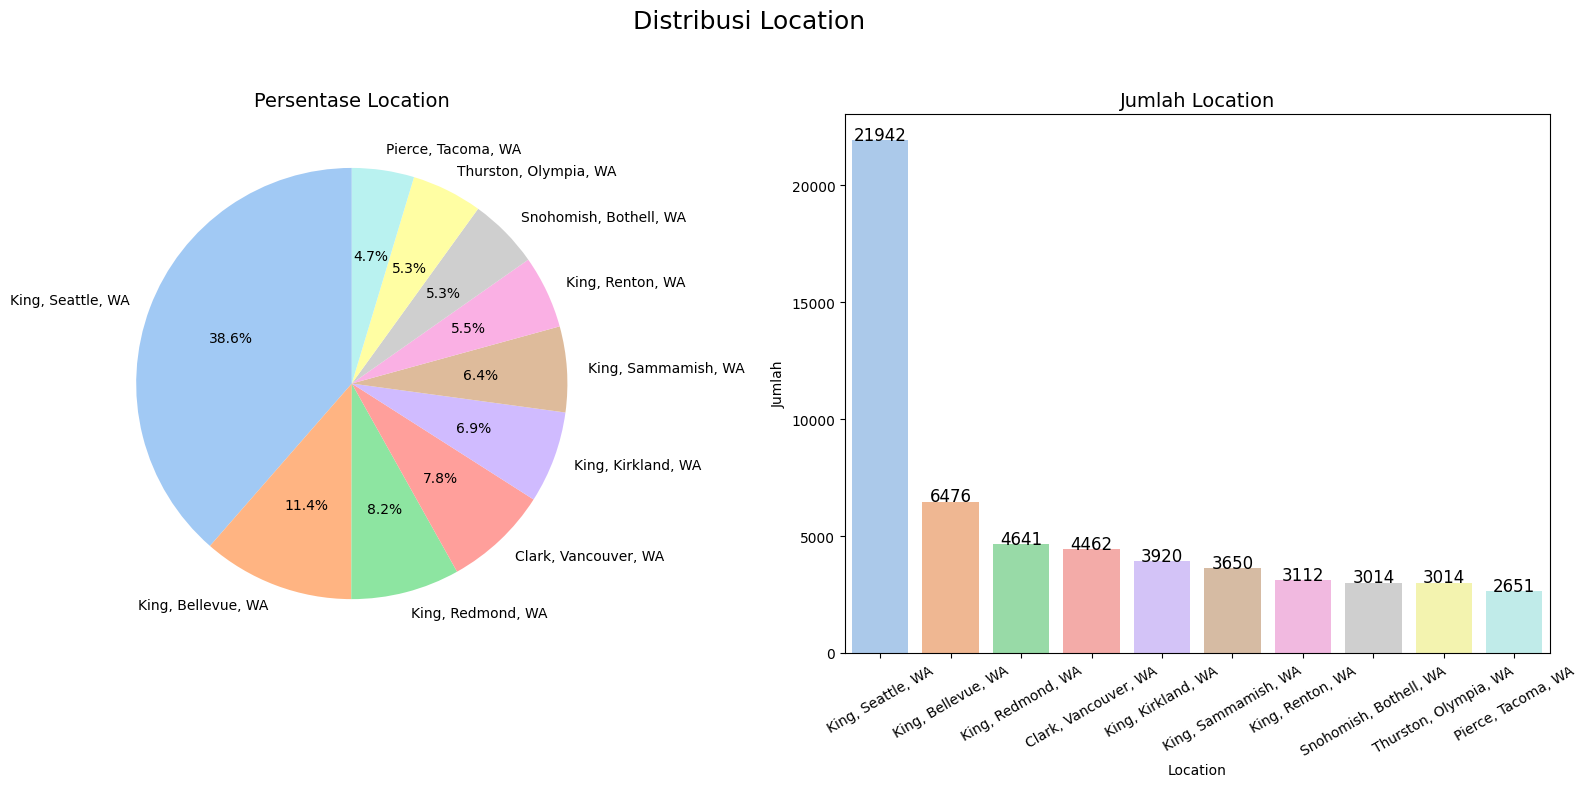

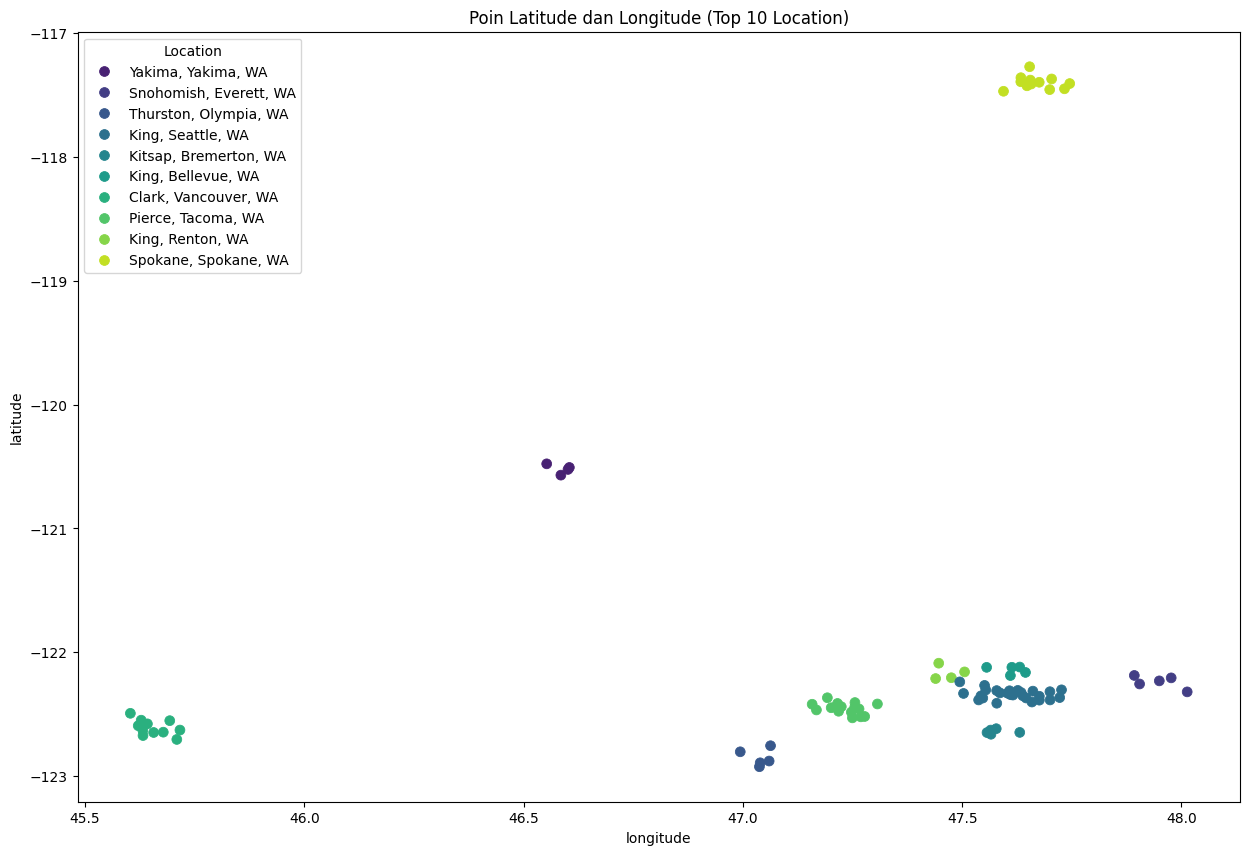

In [19]:
plot_value_counts(df, 'Location', top_n=10)
plot_coordinates_seaborn(df, cmap_column='Location', top_n=10)


Kesimpulan dan Wawasan

Dari jumlah nilai di atas, kami dapat membuat inferensi berikut dan mendapatkan wawasan:

10 lokasi teratas untuk mobil listrik di dataset sebagian besar terletak di negara bagian Washington (WA), tanpa mobil dari negara bagian lain.
Jumlah mobil listrik terbanyak terletak di King County, dengan Seattle memiliki jumlah tertinggi yaitu 21,942 mobil. Ini menunjukkan bahwa sebagian besar mobil listrik terkonsentrasi di daerah perkotaan, terutama di kota-kota besar seperti Seattle dan Bellevue.
Lokasi berikutnya yang paling umum adalah Clark County, dengan Vancouver memiliki jumlah 4,462 mobil.
Berdasarkan analisis, berikut adalah rekomendasi untuk advokasi mobil listrik:
Fokus pada area perkotaan: Karena sebagian besar mobil listrik terletak di area perkotaan, advokasi mobil listrik harus fokus pada mempromosikan penggunaan mobil listrik di kota-kota, terutama di kota besar seperti Seattle dan Bellevue.
Perluas ke kabupaten lain: Meskipun King dan Clark County memiliki jumlah mobil listrik tertinggi, masih ada potensi untuk memperluas penggunaan mobil listrik di kabupaten lain di negara bagian Washington. Advokasi harus mempertimbangkan untuk menjangkau kabupaten ini dan mempromosikan manfaat mobil listrik.
Targetkan kota-kota tertentu: Dalam kabupaten dengan jumlah mobil listrik yang tinggi, mungkin ada kota atau lingkungan tertentu dengan tingkat adopsi yang lebih rendah. Advokasi harus menargetkan area ini dan mempromosikan penggunaan mobil listrik melalui pemasaran dan upaya penyuluhan yang ditargetkan.


Analisis Dataset Mobil Listrik: Kelayakan CAFV

Kolom 'CAFV Eligibility' dalam dataset mobil listrik memberikan informasi tentang apakah mobil listrik memenuhi syarat untuk insentif Clean Alternative Fuel Vehicle (CAFV) berdasarkan jangkauan baterainya. Berikut adalah jumlah nilai dari kolom 'CAFV Eligibility':

<ipython-input-18-ea5d54286d6a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette='pastel')


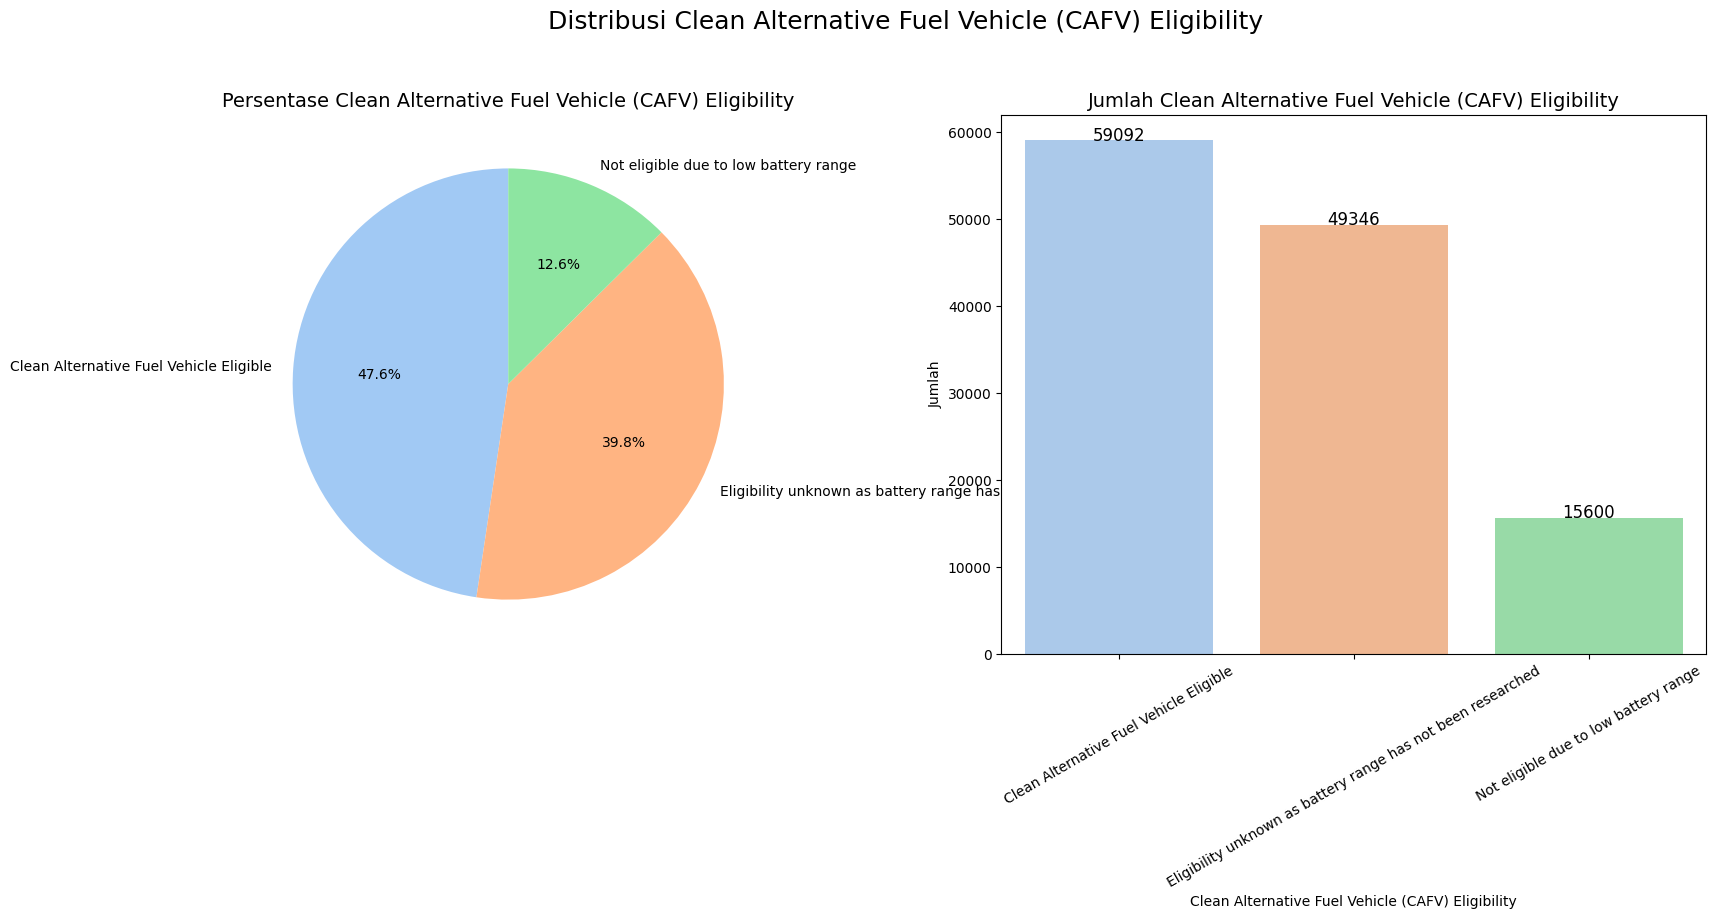

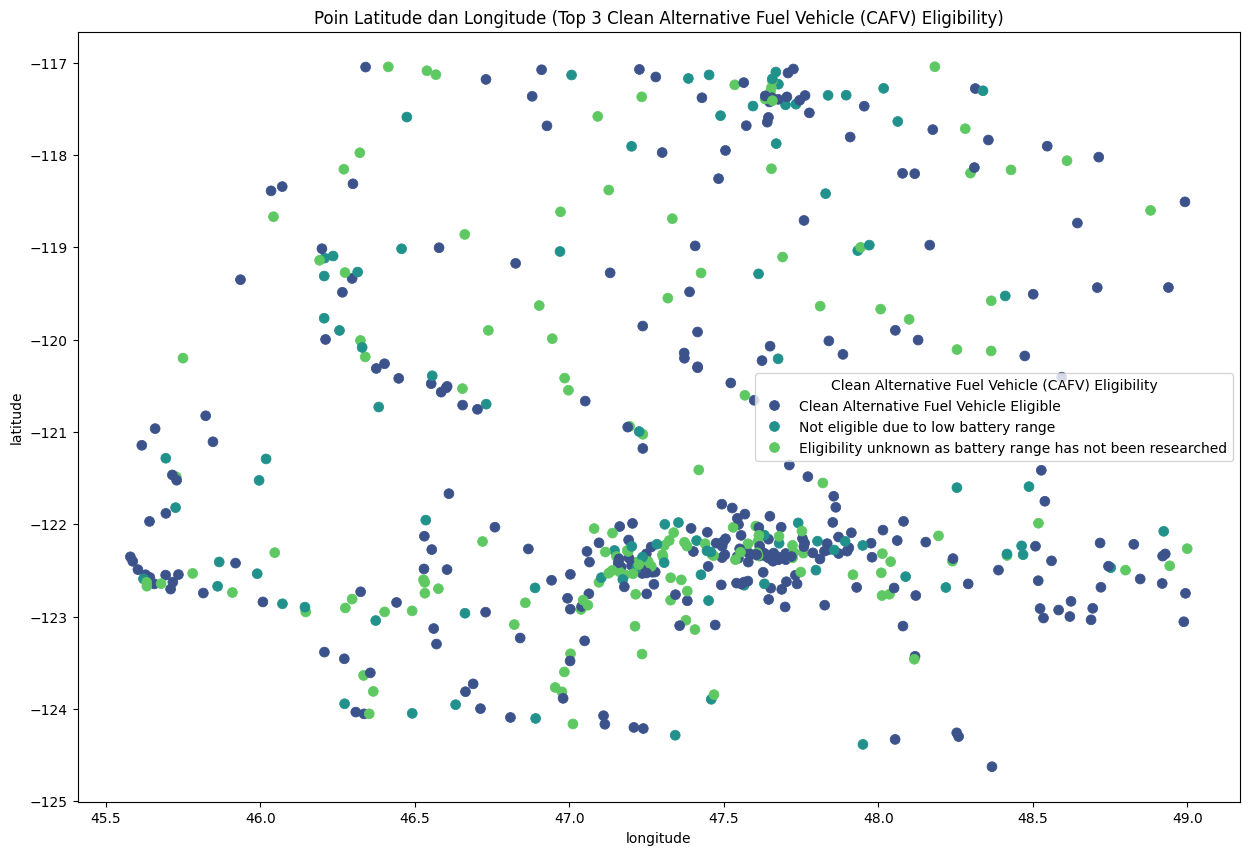

In [20]:
plot_value_counts(df, 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', top_n=3)
plot_coordinates_seaborn(df, cmap_column='Clean Alternative Fuel Vehicle (CAFV) Eligibility', top_n=3)


Kendaraan listrik (EV) semakin mendapatkan perhatian sebagai alternatif yang berkelanjutan dan ramah lingkungan dibandingkan kendaraan dengan mesin pembakaran internal. Karena sektor transportasi merupakan kontributor signifikan terhadap emisi gas rumah kaca, adopsi kendaraan listrik dapat memainkan peran penting dalam mengurangi jejak karbon keseluruhan. Menganalisis data yang tersedia tentang kendaraan listrik dapat memberikan wawasan berharga dan membantu menginformasikan strategi masa depan untuk mempromosikan adopsi mereka.

Berdasarkan jumlah nilai yang disediakan untuk dataset mobil listrik, kami dapat membuat beberapa inferensi dan memberikan rekomendasi berikut:

Promosikan kendaraan bahan bakar alternatif bersih: Sebagian besar (sekitar 47,5%) kendaraan dalam dataset diklasifikasikan sebagai "Clean Alternative Fuel Vehicle Eligible." Ini menunjukkan adanya minat dan adopsi yang berkembang untuk kendaraan listrik. Upaya harus difokuskan pada mendorong lebih banyak pemilik kendaraan untuk memanfaatkan insentif CAFV, serta memberikan informasi yang jelas tentang manfaatnya.

Menangani ketidakpastian dalam kelayakan: Sekitar 41,8% dari kendaraan dalam dataset memiliki kelayakan CAFV yang tidak diketahui karena jangkauan baterai belum diteliti. Strategi harus mencakup peningkatan transparansi tentang kelayakan dan menyediakan data yang lebih baik kepada konsumen tentang jangkauan baterai dan kesesuaiannya dengan kriteria CAFV.

Menyasar kendaraan yang tidak memenuhi syarat: Meskipun jumlahnya lebih kecil, ada sejumlah kendaraan yang tidak memenuhi syarat karena jangkauan baterai yang rendah (sekitar 10,7%). Fokus harus pada perbaikan teknologi baterai dan promosi kendaraan dengan jangkauan yang lebih panjang untuk memenuhi syarat CAFV dan meningkatkan adopsi secara keseluruhan.

Dengan mengembangkan rekomendasi dan strategi berbasis data, pemangku kepentingan dapat mengatasi hambatan yang ada dan lebih efektif mendorong penggunaan kendaraan listrik. Data ini juga dapat membantu dalam merancang kebijakan dan insentif untuk memacu pertumbuhan pasar kendaraan listrik dan kontribusinya terhadap pengurangan emisi karbon.